<div style="background-color: #c3e8fb; padding: 10px; color: #144d84;">
<b>Exercise 1) Flower Classification with Transfer Learning</b><br>
Using the flower dataset, perform transfer learning on the DenseNet-121 network (and fine-tuning if necessary). This model has a parameter called pooling, which is recommended to be set to a reasonable value like 'avg' after reading its documentation.

You must use image_dataset_from_directory to solve this problem.   
You must use Data Augmentation.

</div>

In [46]:
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, \
RandomFlip, RandomRotation, RandomContrast, RandomBrightness, RandomTranslation, Rescaling
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

In [2]:
flowers_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True
)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [3]:
flowers_root

'/root/.keras/datasets/flower_photos'

In [4]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    flowers_root,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    flowers_root,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [5]:
# take samples of validation, to make a test data
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

# Calculate number of samples in val_ds (roughly)
val_batches = tf.data.experimental.cardinality(val_ds).numpy()
num_val_samples = val_batches * batch_size
print(f'Number of samples in validation dataset: {num_val_samples}')

# Calculate number of samples in test_ds (roughly)
test_batches = tf.data.experimental.cardinality(test_ds).numpy()
num_test_samples = test_batches * batch_size
print(f'Number of samples in test dataset: {num_test_samples}')

Number of samples in validation dataset: 608
Number of samples in test dataset: 128


In [6]:
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

<div style="background-color: #c3e8fb; padding: 10px; color: #144d84;">
<b>Exercise 2) Using Other Data Augmentation Methods</b><br>
Refer to the documentation at:
https://www.tensorflow.org/api_docs/python/tf/image/ All functions that start with random_ can be used for data augmentation. Explain three functions that we have not used yet, and add them to the Exercise1's example for plant classification.
</div>

In [9]:
# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip("horizontal_and_vertical"),
#     tf.keras.layers.RandomRotation(0.2),
#     tf.keras.layers.Lambda(lambda x: tf.image.random_brightness(x, max_delta=0.2)),
#     tf.keras.layers.Lambda(lambda x: tf.image.random_contrast(x, lower=0.3, upper=1.0)),
#     tf.keras.layers.Lambda(lambda x: tf.image.random_crop(x, size=[img_height, img_width, 3]))
# ])


In [7]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    # RandomContrast(0.2), # جدید
    # RandomBrightness(0.2), # جدید
    # RandomTranslation(height_factor=0.1, width_factor=0.1) # جدید. برای جابه جایی تصویر
])

In [8]:
base_model = DenseNet121(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

model = tf.keras.Sequential([
    Input(shape=(img_height, img_width, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    Dense(30, activation='relu'),
    Dropout(0.2),
    Dense(20, activation='relu'),
    Dense(5)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 5, 5, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30)                  │          30,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │             620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             105 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,068,979 (26.97 MB)

 Trainable params: 31,475 (122.95 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [9]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 235ms/step - accuracy: 0.3412 - loss: 1.5584 - val_accuracy: 0.7805 - val_loss: 0.6458 - learning_rate: 0.0010
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 105ms/step - accuracy: 0.7503 - loss: 0.7217 - val_accuracy: 0.8630 - val_loss: 0.4127 - learning_rate: 0.0010
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.7941 - loss: 0.5679 - val_accuracy: 0.8795 - val_loss: 0.3407 - learning_rate: 0.0010
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.8250 - loss: 0.4674 - val_accuracy: 0.8944 - val_loss: 0.3159 - learning_rate: 0.0010
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - accuracy: 0.8450 - loss: 0.4124 - val_accuracy: 0.8911 - val_loss: 0.3064 - learning_rate: 0.0010
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.8558 - loss: 0.3903 - val_accuracy: 0.9076 - val_loss: 0.2760 - learning_rate: 0.0010
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.8629 - loss: 0.

In [12]:
model.save('flower_classification_model_without_finetuning.keras')
# model.save('flower_classification_model_without_finetuning.h5')

In [33]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {test_accuracy:.2f}')
print(f'Test loss: {test_loss:.2f}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9208 - loss: 0.2643
Test accuracy: 0.92
Test loss: 0.26


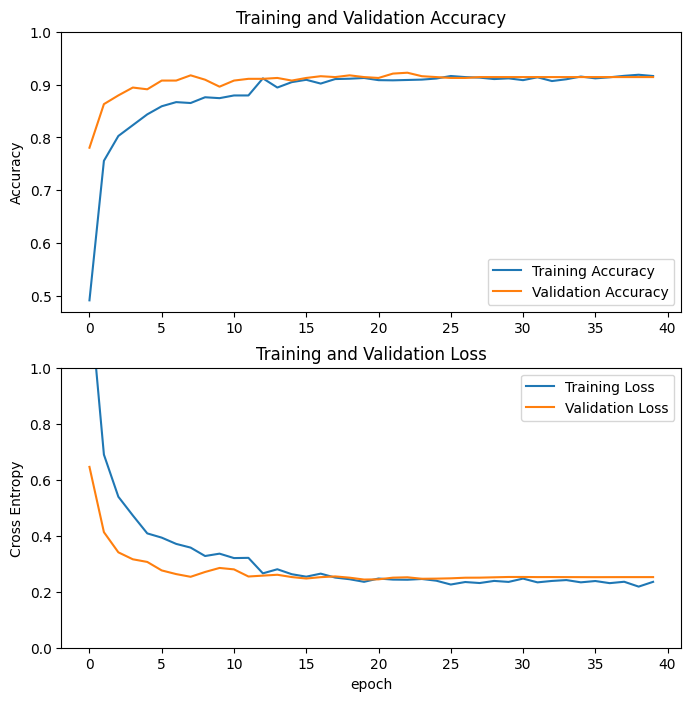

In [24]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine Tuning

In [13]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  427


In [15]:
base_model.trainable = True

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [19]:
base_model.layers[5].trainable

False

In [21]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)


fine_tune_epochs = 20
initial_epoch=history.epoch[-1]
total_epochs =  initial_epoch + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         callbacks=[reduce_lr, early_stopping])

Epoch 40/59
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.9092 - loss: 0.2377 - val_accuracy: 0.9125 - val_loss: 0.2435 - learning_rate: 1.0000e-06
Epoch 41/59
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.9055 - loss: 0.2363 - val_accuracy: 0.9125 - val_loss: 0.2436 - learning_rate: 1.0000e-06
Epoch 42/59
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.9039 - loss: 0.2752 - val_accuracy: 0.9125 - val_loss: 0.2437 - learning_rate: 1.0000e-06
Epoch 43/59
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.9162 - loss: 0.2365 - val_accuracy: 0.9142 - val_loss: 0.2437 - learning_rate: 1.0000e-06
Epoch 44/59
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.8991 - loss: 0.2642 - val_accuracy: 0.9158 - val_loss: 0.2437 - learning_rate: 1.0000e-06
Epoch 45/59
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.9083 - loss: 0.2431 - val_accuracy: 0.9175 - val_loss: 0.2438 - learning_rate: 1.0000e-06
Epoch 46/59
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/ste

فاین تونینگ اوضاع را بهتر نکرد...

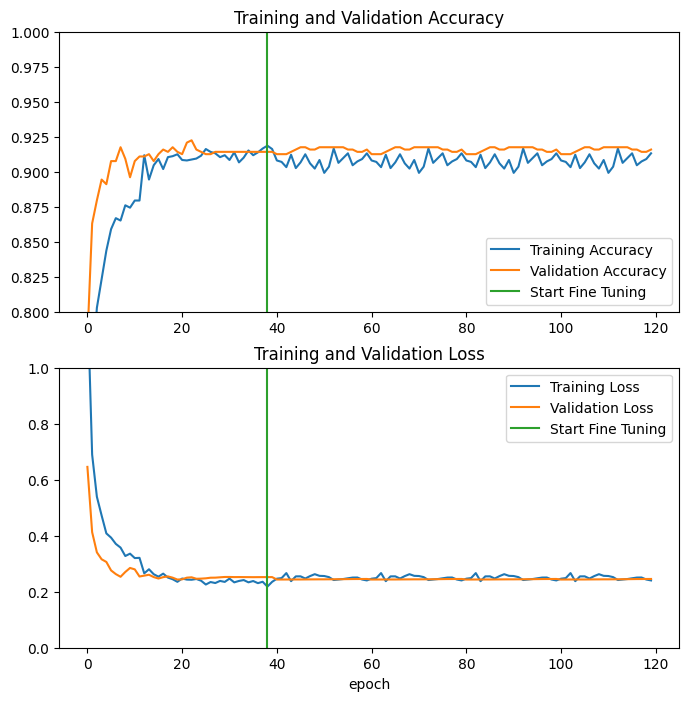

In [28]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epoch-1,initial_epoch-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epoch-1,initial_epoch-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluating on test data

In [34]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {test_accuracy:.2f}')
print(f'Test loss: {test_loss:.2f}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9208 - loss: 0.2643
Test accuracy: 0.92
Test loss: 0.26


### Deployment model

In [30]:
del model
model = tf.keras.models.load_model('flower_classification_model_without_finetuning.keras')

In [32]:
deployment_model = tf.keras.Sequential([
    Input(shape=(img_height, img_width, 3)),
    Rescaling(1./127.5, offset=-1), # or use DenseNet's preprocessing function
    model
])

# deployment_model = tf.keras.Sequential([
#     Input(shape=(img_height, img_width, 3)),
#     Lambda(preprocess_input),
#     model
# ])


deployment_model.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

deployment_model.save('flower_classification_deployment_model.keras')

Using deployment model for prediction

In [102]:
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

def load_preprocess_and_predict_image(image_path):
    image = load_img(image_path, target_size=(180, 180))
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    predictions = deployment_model.predict(image_array)
    predicted_class = np.argmax(predictions[0])
    return class_names[predicted_class]

In [103]:
image_path = 'dandelion-seeds-blowing-in-wind.jpg'
load_preprocess_and_predict_image(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


'dandelion'

In [104]:
image_path = 'sunflower.jpg'
load_preprocess_and_predict_image(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


'sunflowers'

In [105]:
image_path = 'Lavender-Tulips.jpg'
load_preprocess_and_predict_image(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


'roses'